In [2]:
import tensorflow as tf 
from tensorflow.keras import models,layers 
import matplotlib.pyplot as plt 
import numpy as np 

In [3]:

datasets = tf.keras.preprocessing.image_dataset_from_directory("Plant Village1",
                      shuffle =True,
                      image_size=(256,256),
                      batch_size = 32)



Found 2152 files belonging to 3 classes.


In [4]:
class_names = datasets.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

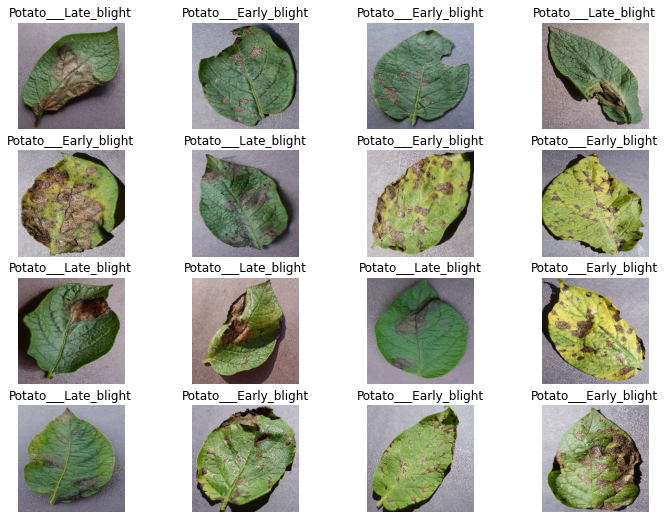

In [5]:
plt.figure(figsize=(12,9))
for image_batch,label_batch in datasets.take(1):
  for i in range (16):
   
    plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [6]:

def get_datasets(ds,train_split=0.8,valid_split=0.1,test_split=0.1,shuffle =True,shuffle_size=10000):

    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    valid_size = int(valid_split*ds_size)
    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    return train_ds,valid_ds,test_ds

In [7]:
train_ds,val_ds,test_ds = get_datasets(datasets)

In [8]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

54
8
6


In [9]:
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
Augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:

inputshape = (32,256,256,3)
n_classes = 3
model = models.Sequential([
    rescale,
    Augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=inputshape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
# build model
model.build(inputshape)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [13]:
history = model.fit(
    train_ds,
    epochs = 20,
    batch_size = 32,
    verbose=1,
    validation_data = val_ds)

Epoch 1/20
54/54 [==============================] - 206s 3s/step - loss: 0.8173 - accuracy: 0.5909 - val_loss: 0.6877 - val_accuracy: 0.6406
Epoch 2/20
54/54 [==============================] - 110s 2s/step - loss: 0.5615 - accuracy: 0.7350 - val_loss: 0.4436 - val_accuracy: 0.7917
Epoch 3/20
54/54 [==============================] - 117s 2s/step - loss: 0.3559 - accuracy: 0.8501 - val_loss: 0.2660 - val_accuracy: 0.8958
Epoch 4/20
54/54 [==============================] - 122s 2s/step - loss: 0.2534 - accuracy: 0.9005 - val_loss: 0.2885 - val_accuracy: 0.8698
Epoch 5/20
54/54 [==============================] - 118s 2s/step - loss: 0.2396 - accuracy: 0.8947 - val_loss: 0.2581 - val_accuracy: 0.9115
Epoch 6/20
54/54 [==============================] - 117s 2s/step - loss: 0.2208 - accuracy: 0.9172 - val_loss: 0.2401 - val_accuracy: 0.9010
Epoch 7/20
54/54 [==============================] - 119s 2s/step - loss: 0.2073 - accuracy: 0.9242 - val_loss: 0.2444 - val_accuracy: 0.8958
Epoch 8/20
54

In [14]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 83s 865ms/step - loss: 0.1262 - accuracy: 0.9375


[0.12619011104106903, 0.9375]

In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

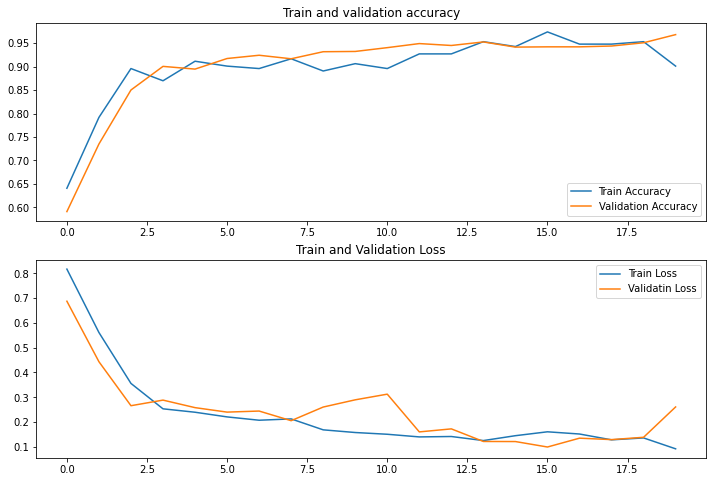

In [18]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(val_accuracy,label = 'Train Accuracy')
plt.plot(train_accuracy,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and validation accuracy')
plt.subplot(2,1,2)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validatin Loss')
plt.title('Train and Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [19]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

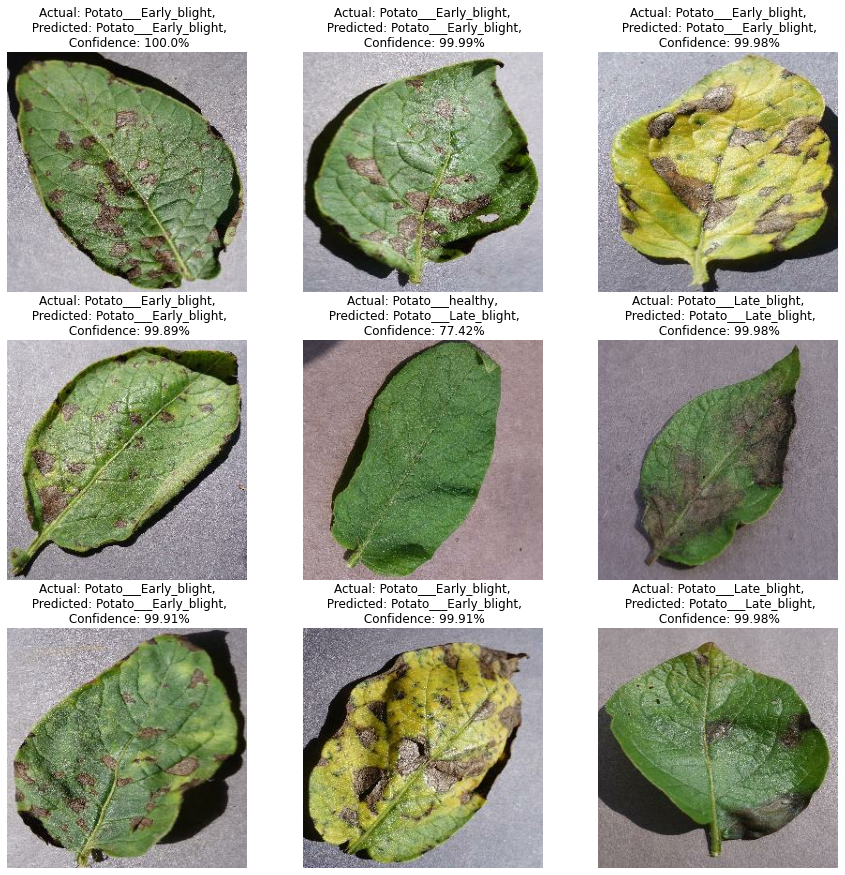

In [20]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: { actual_class},\n Predicted: { predicted_class},\n Confidence: {confidence}%' )
        plt.axis('off')

In [23]:
model.save("potato.h5")
print(tf.__version__)

2.8.0
